In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from collections import defaultdict

In [4]:
train = pd.read_csv("Train.csv")
train = train.sort_values("ClassId").reset_index()
test = pd.read_csv("Test.csv")
main_path = os.getcwd()

In [5]:
train

,index,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,426,30,30,5,5,25,25,0,Train/0/00000_00002_00006.png
1,494,70,74,7,7,64,68,0,Train/0/00000_00004_00014.png
2,495,72,75,7,6,65,68,0,Train/0/00000_00004_00015.png
3,496,74,79,7,7,68,72,0,Train/0/00000_00004_00016.png
4,497,74,80,6,8,67,73,0,Train/0/00000_00004_00017.png
...,...,...,...,...,...,...,...,...,...
39204,39053,40,43,5,6,35,38,42,Train/42/00042_00002_00024.png
39205,39054,42,44,5,5,37,39,42,Train/42/00042_00002_00025.png
39206,39055,45,47,6,6,40,42,42,Train/42/00042_00002_00026.png
39207,39087,68,71,6,6,62,65,42,Train/42/00042_00003_00028.png


Define classes names.

In [6]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }
num_classes = len(classes)

Check the amount of images of each classe to identify possible dataset unbalance. 

Text(40, 1050, 'Pretended Images: 1000.00')

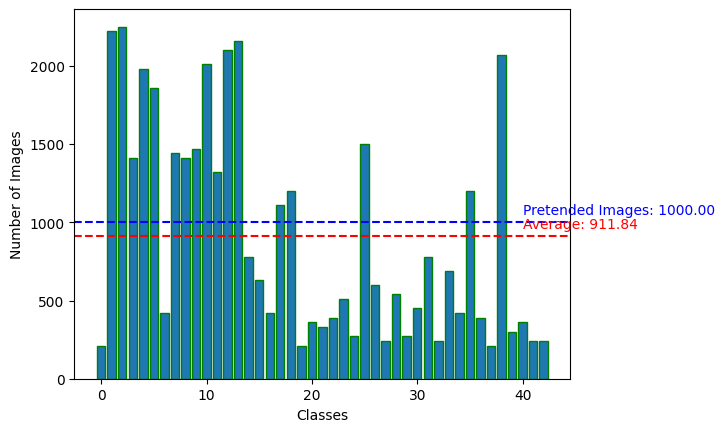

In [7]:
numImages = {}
for i in range(0, num_classes):
    numImages[i] = len(train[train['ClassId'] == i])

plt.bar(numImages.keys(), numImages.values(), edgecolor="green")
plt.xlabel('Classes')
plt.ylabel('Number of Images')
average = np.mean(list(numImages.values()))
plt.axhline(average, color='r', linestyle='--', label='Average')
plt.text(40, average + 50, f"Average: {average:.2f}", color='red')
plt.axhline(1000, color='b', linestyle='--', label='Pretended Images')
plt.text(40, 1000 + 50, f"Pretended Images: {1000:.2f}", color='blue')

Check images's resolution by plotting Width and Height. The size of the dots represent the aspect ratio of the image.

Text(0, 0.5, 'Height')

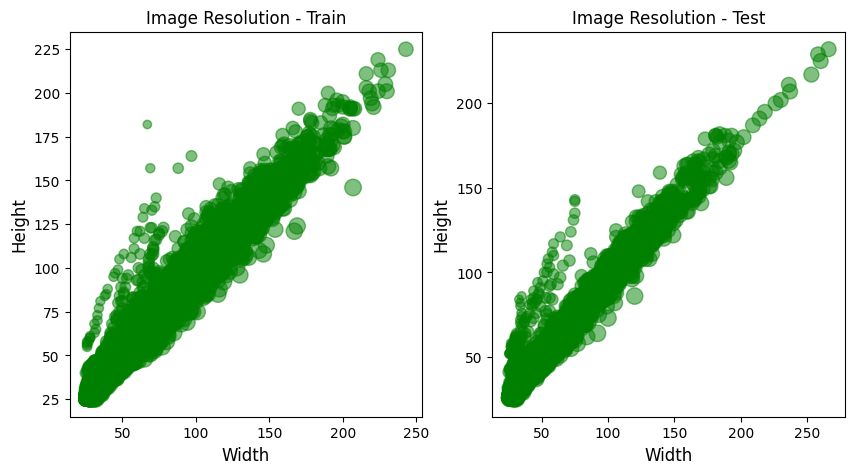

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
points = ax.scatter(train.Width, train.Height, color='green', alpha=0.5, s=(train.Width/train.Height)*100,  picker=True)
ax.set_title("Image Resolution - Train")
ax.set_xlabel("Width", size=12)
ax.set_ylabel("Height", size=12)
ax2 = fig.add_subplot(122)
points = ax2.scatter(test.Width, test.Height, color='green', alpha=0.5, s=(test.Width/test.Height)*100,  picker=True)
ax2.set_title("Image Resolution - Test")
ax2.set_xlabel("Width", size=12)
ax2.set_ylabel("Height", size=12)

Create correct path to the images (assuming they are in the same folder as the notebook)

In [9]:
#Pensava que era preciso, mas não vale a pena criar isto. Usar apenas o path
images_path = []
for path in train["Path"]:
    final_path = main_path + "/" + path
    images_path.append(final_path)
train["Final_path"] = images_path

Create a function to preprocess the images into a numpy array which is required for the model input.

In [10]:
def image_preprocessing(image):
    image = image.resize((32,32))
    image_array = np.array(image)
    return image_array

Define X_train and y_train.

In [11]:
X_train = []
y_train = []
for index, path in enumerate(train.Path):
    try:
        image = Image.open(path)
        image_array = image_preprocessing(image)
        X_train.append(image_array)
        y_train.append(train['ClassId'].iloc[index])
    except:
        print("Error in " + path)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [12]:
roi_train = []
for i in range(0, len(train)):
    roi_x1, roi_y1, roi_x2, roi_y2 = train['Roi.X1'].iloc[i], train['Roi.Y1'].iloc[i], train['Roi.X2'].iloc[i], train['Roi.Y2'].iloc[i]
    # Adjust bounding box coordinates for resizing
    resized_roi_x1 = round(roi_x1 * 32 / train['Width'].iloc[i])
    resized_roi_y1 = round(roi_y1 * 32 / train['Height'].iloc[i])
    resized_roi_x2 = round(roi_x2 * 32 / train['Width'].iloc[i])
    resized_roi_y2 = round(roi_y2 * 32 / train['Height'].iloc[i])
    roi_train.append([resized_roi_x1, resized_roi_y1, resized_roi_x2, resized_roi_y2])
    if i in [1000, 5000, 10000, 20000, 30000, 35000]:
        print(i)
roi_train = np.array(roi_train)

1000
5000
10000
20000
30000
35000


One hot encode the classes in y_train

In [13]:
y_train = keras.utils.to_categorical(y_train, num_classes)
print(X_train.shape)
print(y_train.shape)

(39209, 32, 32, 3)
(39209, 43)


Define X_test and y_test

In [14]:
X_test = []
y_test = []
for index, path in enumerate(test.Path):
    try:
        image = Image.open(path)
        image_array = image_preprocessing(image)
        X_test.append(image_array)
        y_test.append(test['ClassId'].iloc[index])
    except:
        print("Error in " + path)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_test.shape)
print(y_test.shape)

(12630, 32, 32, 3)
(12630, 43)


In [16]:
#X_train = []
#y_train= []
#for path in train.Path:
    #try:
        #image = cv2.imread(path) #Gets the image in array shape
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Change back to RGB
        #image = Image.fromarray(image, 'RGB')
        #image = image.resize((32, 32))
        #image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
        #X_train.append(np.array(image))
    #except:
        #print("Error in " + path)


Image augmentation and reduction of each class to around a 1000.

In [17]:
indexes_to_delete = []
count = 0
for label, images_num in enumerate(numImages.values()):
    if images_num > 1000:
        np.random.shuffle(X_train[count:count+images_num])
        downsize = images_num - 1000
        indexes = [x for x in range(count, count+downsize)]
        indexes_to_delete.append(indexes)
        count = count + images_num
    else:
        count = count + images_num
indexes_to_delete = sum(indexes_to_delete, [])
X_train2 = np.delete(X_train, indexes_to_delete, axis = 0)
y_train2 = np.delete(y_train, indexes_to_delete, axis = 0)
roi_train2 = np.delete(roi_train, indexes_to_delete, axis = 0)
print(X_train2.shape)
print(y_train2.shape)
print(roi_train2.shape)

(27499, 32, 32, 3)
(27499, 43)
(27499, 4)


Text(40, 689.5116577148438, 'Average: 639.51')

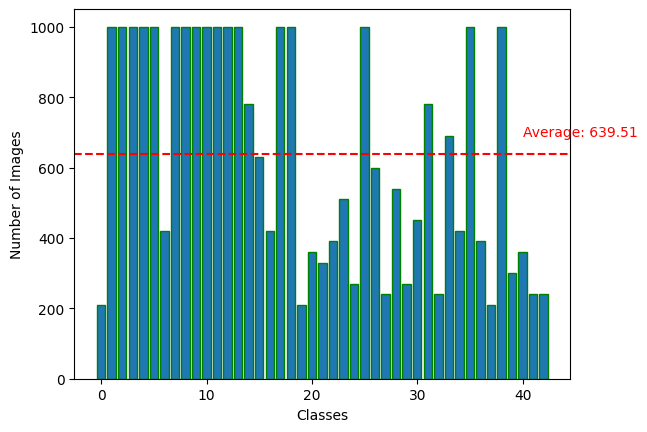

In [18]:
x = np.sum(y_train2, axis = 0)
plt.bar(range(0,43), np.sum(y_train2, axis=0), edgecolor="green")
plt.xlabel('Classes')
plt.ylabel('Number of Images')
average = np.mean(np.sum(y_train2, axis=0))
plt.axhline(average, color='r', linestyle='--', label='Average')
plt.text(40, average + 50, f"Average: {average:.2f}", color='red')

In [19]:
image_generator = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=.2,
    fill_mode="nearest")

In [20]:
count = 0
for label, images_num in enumerate(np.sum(y_train2, axis=0)):
    if int(images_num) < 1000:
        augmentation = 1000 - int(images_num)
        while augmentation != 0:
            index = random.randint(count, count+int(images_num))

            image = X_train2[index]
            params = image_generator.get_random_transform((1,32,32,3))
            width_shift = params['tx']
            height_shift = params['ty']
            zoom_x = params['zx']
            zoom_y = params['zy']
            image = image_generator.apply_transform(image, params)
            image = np.expand_dims(image, axis = 0)
            
            X_train2 = np.insert(X_train2, count, image, axis = 0)
            y_train2 = np.insert(y_train2, count, y_train2[count], axis = 0)
            
            rx1, ry1, rx2, ry2 = roi_train2[index]
            roi_x1 = (rx1 + width_shift) * zoom_x 
            roi_x2 = (rx2 + width_shift) * zoom_x
            roi_y1 = (ry1 - height_shift ) * zoom_y
            roi_y2 = (ry2 - height_shift ) * zoom_y
            roi_train2 = np.insert(roi_train2, count, np.array([roi_x1, roi_y1, roi_x2, roi_y2]), axis = 0)
            augmentation = augmentation - 1
        count = count + 1000 
    else:
        count = count + int(images_num)

In [21]:
print(X_train2.shape)
print(y_train2.shape)
print(roi_train2.shape)

(43000, 32, 32, 3)
(43000, 43)
(43000, 4)


Text(40, 1050.0, 'Average: 1000.00')

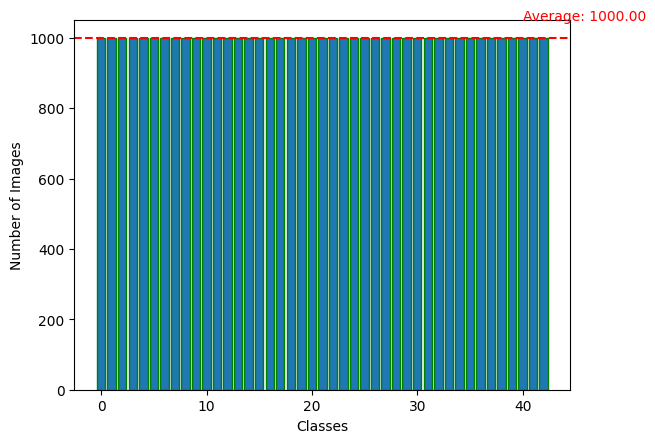

In [22]:
x = np.sum(y_train2, axis = 0)
plt.bar(range(0,43), np.sum(y_train2, axis=0), edgecolor="green")
plt.xlabel('Classes')
plt.ylabel('Number of Images')
average = np.mean(np.sum(y_train2, axis=0))
plt.axhline(average, color='r', linestyle='--', label='Average')
plt.text(40, average + 50, f"Average: {average:.2f}", color='red')

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


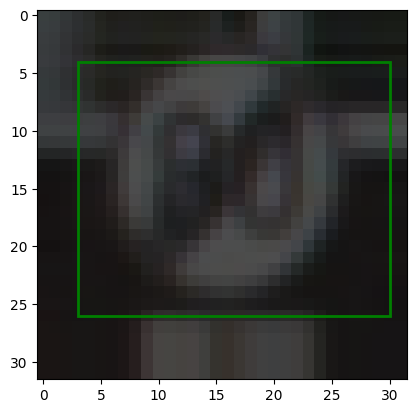

In [152]:
index = 6237
r1x, r1y, r2x, r2y = roi_train2[index]
print(y_train2[index])
image_test = X_train2[index]
fig, ax = plt.subplots()
ax.imshow(image_test)
roi_x1 = (rx1 + width_shift) * zoom_x 
roi_x2 = (rx2 + width_shift) * zoom_x
roi_y1 = (ry1 - height_shift ) * zoom_y
roi_y2 = (ry2 - height_shift ) * zoom_y
roi_width = (r2x - r1x)
roi_height = (r2y - r1y)
rect = patches.Rectangle((r1x, r1y), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


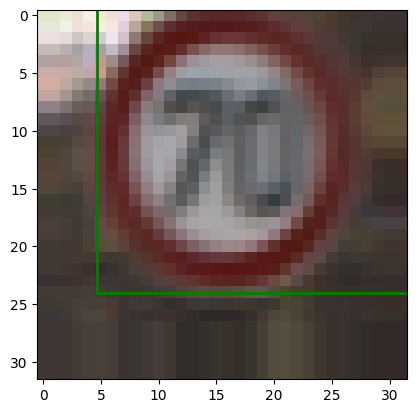

In [147]:
index = 6765
image = X_train[index]
params = image_generator.get_random_transform((1,32,32,3))
width_shift = params['tx']
height_shift = params['ty']
zoom_x = params['zx']
zoom_y = params['zy']
image = image_generator.apply_transform(image, params)
image = np.expand_dims(image, axis = 0)
rx1, ry1, rx2, ry2 = roi_train[index]
print(y_train[index])
fig, ax = plt.subplots()
ax.imshow(image[0])
roi_x1 = (rx1 + width_shift) * zoom_x 
roi_x2 = (rx2 + width_shift) * zoom_x
roi_y1 = (ry1 - height_shift ) * zoom_y
roi_y2 = (ry2 - height_shift ) * zoom_y
roi_width = (roi_x2 - roi_x1)
roi_height = (roi_y2 - roi_y1)
rect = patches.Rectangle((roi_x1, roi_y1), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

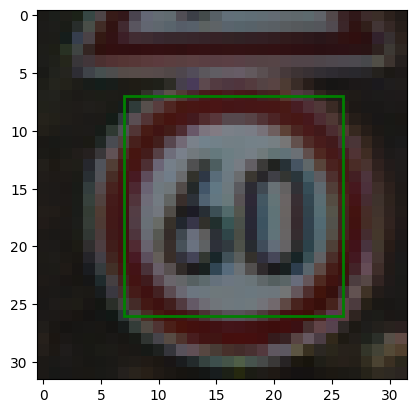

In [87]:
fig, ax = plt.subplots()
ax.imshow(X_train[index])
roi_width = (rx2 - rx1)
roi_height = (ry2 - ry1)
rect = patches.Rectangle((rx1, ry1), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.show()

In [42]:
X_train.shape

(39209, 32, 32, 3)

In [58]:
image2 = image_generator.apply_transform(image[0], params)

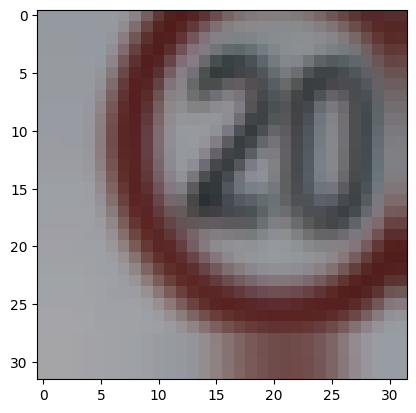

In [59]:
plt.imshow(image2)

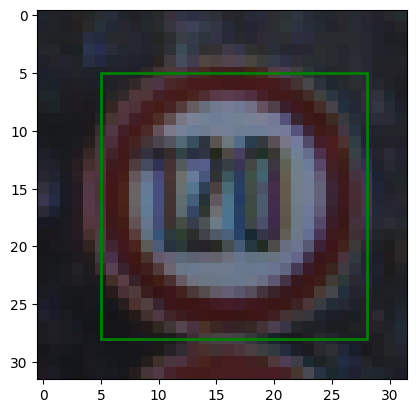

In [523]:
image2 = X_train[12235]
roi_x1 = roi_train[12235][0]
roi_y1 = roi_train[12235][1]
roi_x2 = roi_train[12235][2]
roi_y2 = roi_train[12235][3]

#roi_x1 = train['Roi.X1'].iloc[0]
#roi_y1 = train['Roi.Y1'].iloc[0]
#roi_x2 = train['Roi.X2'].iloc[0]
#roi_y2 = train['Roi.Y2'].iloc[0]

# Create a figure and subplot
fig, ax = plt.subplots()

# Display the image
ax.imshow(image2)

# Create a rectangle patch for the ROI
roi_width = roi_x2 - roi_x1
roi_height = roi_y2 - roi_y1
rect = patches.Rectangle((roi_x1, roi_y1), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none')

# Add the ROI rectangle to the plot
ax.add_patch(rect)

# Show the plot
plt.show()

In [524]:
image2 = X_train[12235]
params = image_generator.get_random_transform((1,32,32,3))
rotation_angle = params['theta']
width_shift = params['tx']
height_shift = params['ty']
zoom_x = params['zx']
zoom_y = params['zy']
image3 = image_generator.apply_transform(image2, params)

In [486]:
image3 = np.expand_dims(image3, axis = 0)
image3.shape

(1, 32, 32, 3)

In [525]:
print(width_shift)
print(height_shift)
print(zoom_x)
print(zoom_y)

0.13036939119372443
-2.6109978091745436
0.8297281818651141
0.9222427192744063


In [528]:
Diferença = 1 - zoom_x
zoom_x = 1 + Diferença

Diferença = 1 - zoom_y
zoom_y = 1 + Diferença

In [475]:
#new_roi_x1 = (roi_x1 * zoom_x) + width_shift
#new_roi_x2 = (roi_x2 * zoom_x) + width_shift
#new_roi_y1 = (roi_y1 * zoom_y) - height_shift 
#new_roi_y2 = (roi_y2 * zoom_y) - height_shift


In [529]:
new_roi_x1 = (roi_x1+ width_shift) * zoom_x 
new_roi_x2 = (roi_x2+ width_shift) * zoom_x
new_roi_y1 = (roi_y1 - height_shift ) * zoom_y
new_roi_y2 = (roi_y2 - height_shift ) * zoom_y

In [477]:
#new_roi_x1 = roi_x1 + width_shift
#new_roi_x2 = roi_x2 + width_shift
#new_roi_y1 = roi_y1 - height_shift 
#new_roi_y2 = roi_y2 - height_shift

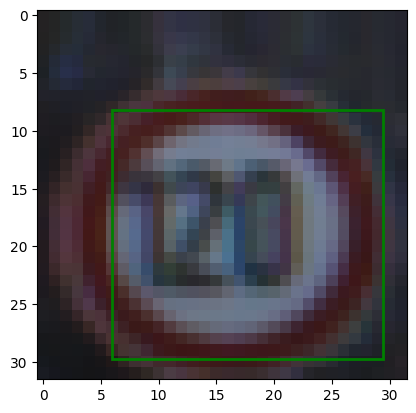

In [530]:
image2 = X_train[0]
roi_x1 = train['Roi.X1'].iloc[0]
roi_y1 = train['Roi.Y1'].iloc[0]
roi_x2 = train['Roi.X2'].iloc[0]
roi_y2 = train['Roi.Y2'].iloc[0]
# Create a figure and subplot
fig, ax = plt.subplots()

# Display the image
ax.imshow(image3)

# Create a rectangle patch for the ROI
new_roi_width = (new_roi_x2 - new_roi_x1)
new_roi_height = (new_roi_y2 - new_roi_y1)
rect = patches.Rectangle((new_roi_x1, new_roi_y1), new_roi_width, new_roi_height, linewidth=2, edgecolor='g', facecolor='none')

# Add the ROI rectangle to the plot
ax.add_patch(rect)

# Show the plot
plt.show()

In [102]:
new_roi_x1 = (roi_x1 + width_shift) * zoom_x
new_roi_x2 = (roi_x2 + width_shift) * zoom_x
new_roi_y1 = (roi_y1 - height_shift) * zoom_y
new_roi_y2 = (roi_y2 - height_shift) * zoom_y

5
25
5
25


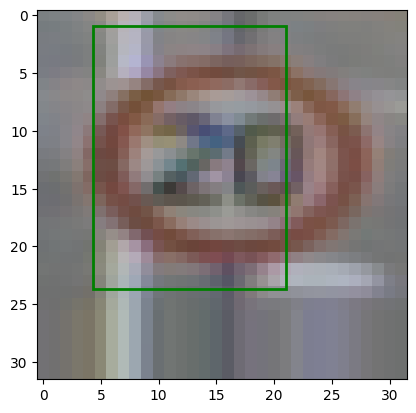

In [145]:
updated_roi_x1 = (roi_x1 + width_shift) * zoom_x
updated_roi_y1 = (roi_y1 - height_shift) * zoom_y
updated_roi_x2 = (roi_x2 + width_shift) * zoom_x
updated_roi_y2 = (roi_y2 - height_shift) * zoom_y

# Create a figure and subplot
fig, ax = plt.subplots()

# Display the image
ax.imshow(image3)

# Create a rectangle patch for the updated ROI
roi_width = updated_roi_x2 - updated_roi_x1
roi_height = updated_roi_y2 - updated_roi_y1
rect = patches.Rectangle((updated_roi_x1, updated_roi_y1), roi_width, roi_height, linewidth=2, edgecolor='g', facecolor='none')

# Add the updated ROI rectangle to the plot
ax.add_patch(rect)

# Show the plot
plt.show()